# Training a Model with Sparsity in Mind

In this document we show how to train a model while using the sparsity flow.

Before going into details, let us define the model.

In [1]:
import os

import torch
from torch import nn
from torch.ao import sparsity

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cpu')

In [2]:
in_features = 7
num_classes = 10

def make_model():
    model = nn.Sequential(
        nn.Linear(in_features, 32),
        nn.ReLU(),
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes)
    )
    return model

model = make_model()
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
)


Given the model above, here are the requirements for its pruning:

- `model[0]`:
    - `sparsity_level = 0.7`
    - `sparse_block_shape = (4, 1)`
- `model[2]`:
    - `sparsity_level = 0.9`
    - `sparse_block_shape = (1, 8)`
- `model[4]`:
    - `sparsity_level = 0.8`
    - `sparse_block_shape = (1, 4)`

## Option 1. Training with Sparsity

This option is the simplest, and is very similar to sparsifying a model for inference. The only difference is that the `sparsifier.step()` will be called inside the training loop.

In [3]:
# Make model
model = make_model()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Make spasity configurations
sparse_config = [
    {'module': model[0], 'sparsity_level': 0.7, 'sparse_block_shape': (4, 1), 'zeros_per_block': 4},
    {'module': model[2], 'sparsity_level': 0.9, 'sparse_block_shape': (1, 8), 'zeros_per_block': 8},
    # The following layers will take default parameters
    model[4],
]

sparse_defaults = {
    'sparsity_level': 0.8,
    'sparse_block_shape': (1, 4),
    'zeros_per_block': 4
}

# Create a sparsifier and attach a model to it
sparsifier = sparsity.WeightNormSparsifier(**sparse_defaults)
sparsifier.prepare(model, config=sparse_config)
sparsifier.step()  # This is optional

/home/zafar/Git/pytorch-dev/pytorch/torch/_tensor.py:565: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /home/zafar/Git/pytorch-dev/pytorch/aten/src/ATen/native/BinaryOps.cpp:506.)
  return torch.floor_divide(self, other)


Notice in the configuration above that we run the `sparsifier.step()` before the training even starts. This is optional, and the only reason you would want to call it before training is if you would like to make sure that the very first iteration of the training loop will receive the sparse model.


*Note: as we are not focusing on accuracy, the example below is just a random input training*

In [4]:
EPOCHS = 5
batch_size = 100

for epoch in range(EPOCHS):
    x = torch.randn(batch_size, in_features)
    y = torch.randint(0, num_classes, size=(batch_size,))

    optimizer.zero_grad()
    y_hat = model(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    sparsifier.step()  # This sparsifies the weights at every iteration
    
    # print statistics
    with torch.no_grad():
        sparsity_levels = [(t.weight == 0).float().mean() for n, t in model.named_modules() if isinstance(t, nn.Linear)]
        sparsity_levels = ', '.join(list(map(lambda x: f'{x:.2%}', sparsity_levels)))
        print(f'{epoch+1}/{EPOCHS}:', end='')
        print(f'\t- Loss: {loss.item():.2f}')
        print(f'\t- Sparsity per layer: {sparsity_levels}')

1/5:	- Loss: 2.33
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%
2/5:	- Loss: 2.31
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%
3/5:	- Loss: 2.30
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%
4/5:	- Loss: 2.30
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%
5/5:	- Loss: 2.30
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%


In [5]:
# Take a step
sparsifier.squash_mask()

In [6]:
# Check sparsity after pruning
with torch.no_grad():
    sparsity_levels = [(t.weight == 0).float().mean() for n, t in model.named_modules() if isinstance(t, nn.Linear)]
    sparsity_levels = ', '.join(list(map(lambda x: f'{x:.2%}', sparsity_levels)))
    print(f'Sparsity per layer: {sparsity_levels}')

Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%


## Option 2. Train the Model while Gradually Increasing Sparsity

Another option that is supported is sparsity level scheduling. The problem with the sparse training is that we zero out a lot of elements in the very beginning of the training. However, most of the time, we would like to gradually increase the level of sparsity as the training progresses. To do that you might want to use `sparsity.scheduler.LambdaSL`, which changes the target level of sparsity by  a factor defined by some lambda function.

For example, let us define the lambda to be a stepping function, which scales the target level of sparsity by 0x at epoch 0, 0.5x at epoch 1, 0.75x at epoch 2, and 1.0x thereafter.

Text(0.5, 1.0, 'Sparsity level Scheduling')

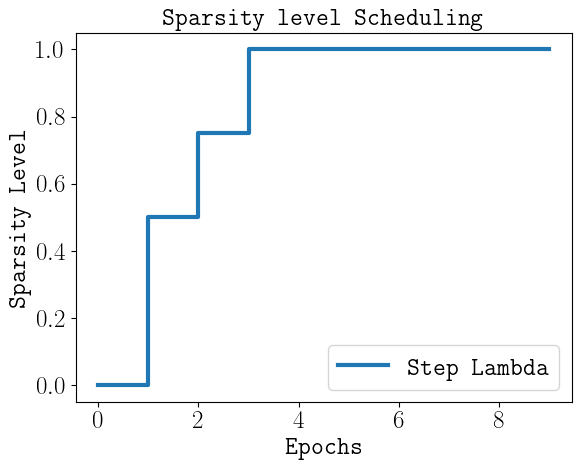

In [7]:
import numpy as np

def stepping_lambda(epoch):
    steps = [0.0, 0.5, 0.75, 1.0]
    if epoch >= len(steps):
        return 1.0
    return steps[epoch]

epochs = np.arange(10)
sl = list(map(stepping_lambda, epochs))

plt.step(epochs, sl, label='Step Lambda', where='post')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Sparsity Level')
plt.title(f'Sparsity level Scheduling')

Now that the function is done, we can attach an instantiated sparsifier and this function to a `LambdaSL` scheduler using the syntax:

```
scheduler = LambdaSL(sparsifier_instance, lambda_fn)
```

In [8]:
model = make_model()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

sparse_config = [
    {'module': model[0], 'sparsity_level': 0.7, 'sparse_block_shape': (4, 1), 'zeros_per_block': 4},
    {'module': model[2], 'sparsity_level': 0.9, 'sparse_block_shape': (1, 8), 'zeros_per_block': 8},
    # The following layers will take default parameters
    model[4],
]

sparse_defaults = {
    'sparsity_level': 0.8,
    'sparse_block_shape': (1, 4),
    'zeros_per_block': 4
}

sparsifier = sparsity.WeightNormSparsifier(**sparse_defaults)
sparsifier.prepare(model, config=sparse_config)
scheduler = sparsity.LambdaSL(sparsifier, stepping_lambda)  # Scheduler attaches to the sparsifier

In [9]:
EPOCHS = 5
batch_size = 100

for epoch in range(EPOCHS):
    x = torch.randn(batch_size, in_features)
    y = torch.randint(0, num_classes, size=(batch_size,))

    optimizer.zero_grad()
    y_hat = model(x)
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
    sparsifier.step()  # This sparsifies the weights at every iteration
    scheduler.step()  # This changes the level of sparsity at every iteration
    
    # print statistics
    with torch.no_grad():
        sparsity_levels = [(t.weight == 0).float().mean() for n, t in model.named_modules() if isinstance(t, nn.Linear)]
        sparsity_levels = ', '.join(list(map(lambda x: f'{x:.2%}', sparsity_levels)))
        print(f'{epoch+1}/{EPOCHS}:', end='')
        print(f'\t- Loss: {loss.item():.2f}')
        print(f'\t- Sparsity per layer: {sparsity_levels}')

1/5:	- Loss: 2.31
	- Sparsity per layer: 0.00%, 0.00%, 0.00%, 0.00%
2/5:	- Loss: 2.29
	- Sparsity per layer: 35.71%, 45.02%, 39.99%, 0.00%
3/5:	- Loss: 2.32
	- Sparsity per layer: 51.79%, 67.48%, 60.01%, 0.00%
4/5:	- Loss: 2.32
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%
5/5:	- Loss: 2.30
	- Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%


Note that the level of sparsity is slowly increasing, based on the logic that we described in the lambda function.

Also, **don't forget to squash the masks**

In [10]:
sparsifier.squash_mask()
# Check sparsity after pruning
with torch.no_grad():
    sparsity_levels = [(t.weight == 0).float().mean() for n, t in model.named_modules() if isinstance(t, nn.Linear)]
    sparsity_levels = ', '.join(list(map(lambda x: f'{x:.2%}', sparsity_levels)))
    print(f'Sparsity per layer: {sparsity_levels}')

Sparsity per layer: 69.64%, 90.04%, 79.98%, 0.00%


In [11]:
model

Sequential(
  (0): Linear(in_features=7, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
)